In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from math import *
import numpy as np
import h5py

from OpticalBeam import *

In [2]:
help(SingleComponentBeam)

Help on class SingleComponentBeam in module OpticalBeam:

class SingleComponentBeam(builtins.object)
 |  SingleComponentBeam(f, nx, ny, dx, dy)
 |  
 |  This class describes an optical beam sampled at on observation plane
 |  perpendicular to the direction of propagation. Only one frequency
 |  component is described, for polychromatic beams several objects of
 |  this class need to be combined.
 |  
 |  The optical beam is given by an array of complex amplitudes on a rectangular grid.
 |  The amplitude refers to the elektric field strength. The power density is the
 |  square of the absolute value of the amplitude.
 |  The dimensions of that grid are given when creating the beam object.
 |  Both values should be integer powers of 2 in order to allow fast Fourier transforms.
 |  
 |  The amplitudes are stored in a 2-dim complex-valued NumPy array.
 |  To ease the Fourier transforms the array are stored in an unconventional order.
 |  The index=0 elements always refer to the center of t

# Single-Frequency content of the radiation field
# recorded on a screen in a TEUFEL run

### Get the file name:
Instead of using a fixed path string one can use a Tk dialog
to browse for the file to be read.

In [3]:
radfile = "/home/lehnertu/Programming/teufel/elbe-u300_screen_5m.h5"

In [6]:
from tkinter import Tk
from tkinter import filedialog

Tk().withdraw()
radfile = filedialog.askopenfilenames()[0]
print(radfile)

/home/lehnertu/Programming/teufel/elbe-u300_screen_10m.h5


### Read the file, import the data and report the geometry:

In [4]:
help(ImportTeufelSingleFrequency)

Help on function ImportTeufelSingleFrequency in module OpticalBeam:

ImportTeufelSingleFrequency(filename, freq)
    Create SingleComponentBeam() objects importing fields on a rectangular screen
    from a TEUFEL calculation. A list of two beams [beam_S, beam_P] is returned
    containing the two polarization directions.



The frequency is coaxed to the nearest frequency in the FFT raster of the given data.<br>
The two polarization directions are taken as the alignment vectors of the screen.<br>
Longitudinal fields are neglected.<br>
Only the amplitude of the E field is considered because the
B fields should be linked to E by Maxwells equations.

In [72]:
[beam_S, beam_P] = ImportTeufelSingleFrequency(radfile, 1.0e12)
print("P=(%.3g, %.3g)" % (beam_S.TotalPower(),beam_P.TotalPower()))

Nx=64 Ny=64
t0=2.33495e-08 dt=1e-13 NOTS=1000
P=(2.73e+11, 5.62e+10)


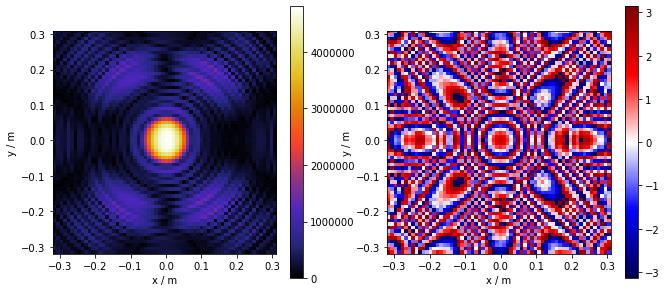

In [73]:
beam_S.plot()
plt.show()

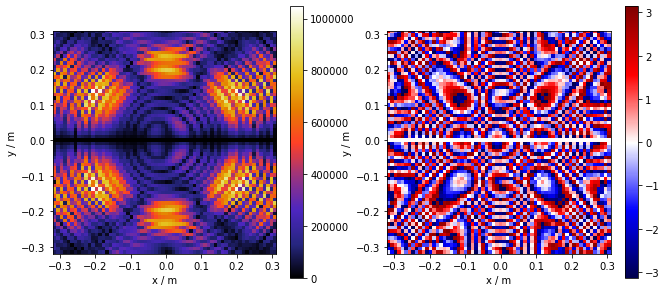

In [74]:
beam_P.plot()
plt.show()

In [40]:
print(beam_S.FitSizeW(order=2))
print(beam_S.FitSizeW(order=4))
print(beam_S.FitSizeW(order=6))
print(beam_S.FitSizeW(order=8))
print(beam_S.FitSizeW(order=10))
print(beam_S.FitSizeW(order=12))
print(beam_S.FitSizeW(order=20))

(0.3513787516861559, 0.4903912660284729)
(0.25200296741307826, 0.0)
(0.1831911018376142, 0.30603017779704234)
(0.11722709844212618, 0.1102910661052316)
(0.07909695441554687, 0.06976946361207888)
(0.0, 0.0)
(620524.473684087, 456332.74225200305)


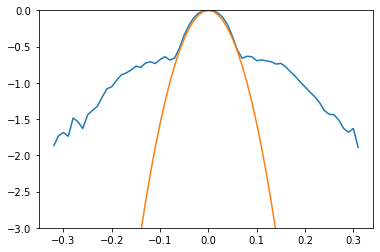

In [42]:
pos, amp = beam_S.Projection(axis='x')
amp = np.log(amp)
amp = amp - np.max(amp)
w = 0.08
gauss = -1.0/(w*w)*np.power(pos,2)
plt.plot(pos,amp)
plt.plot(pos,gauss)
plt.ylim(-3,0)
plt.show()

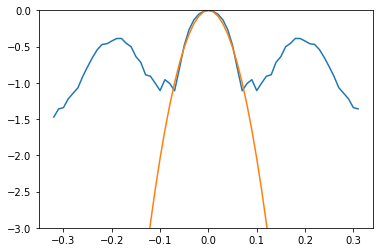

In [43]:
pos, amp = beam_S.Projection(axis='y')
amp = np.log(amp)
amp = amp - np.max(amp)
w = 0.07
gauss = -1.0/(w*w)*np.power(pos,2)
plt.plot(pos,amp)
plt.plot(pos,gauss)
plt.ylim(-3,0)
plt.show()

In [44]:
print(beam_S.FitSizeW(order=2, threshold=-1.5))
print(beam_S.FitSizeW(order=4, threshold=-1.5))
print(beam_S.FitSizeW(order=6, threshold=-1.5))
print(beam_S.FitSizeW(order=8, threshold=-1.5))

(0.2692282449738282, 0.23645009881054502)
(0.14322096657023933, 0.1417550021770221)
(0.06796763547833154, 0.0765667368756699)
(0.05218240063262086, 0.057225228385966304)


## plot a Gaussian beam as reference

In [45]:
help(SingleComponentBeam.GaussianBeam)

Help on method GaussianBeam in module OpticalBeam:

GaussianBeam(f, nx, ny, dx, dy, zR, z) method of builtins.type instance
    Create a gaussian beam with a Rayleigh range zR
    at a distance z from the waist (both polarization directions are equal).
    z cannot be exactly zero.



The eqivalent Gaussian beam shows a waist at the undulator center.
The Rayleigh length is about one fourth the undulator length.

λ = 0.299792 mm
k = 20958.450220 m⁻¹
w0 = 7.566779 mm
w = 63.511379 mm
R = 5.072197 m
(0.06351137855027045, 0.06351137855027082)


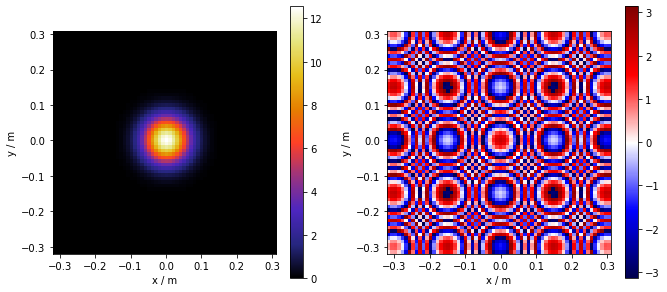

In [66]:
gb = SingleComponentBeam.GaussianBeam(1.0e12, beam_S.nx, beam_S.ny, beam_S.dx, beam_S.dy, 0.6, 5.0002)
print(gb.FitSizeW())
gb.plot()
plt.show()

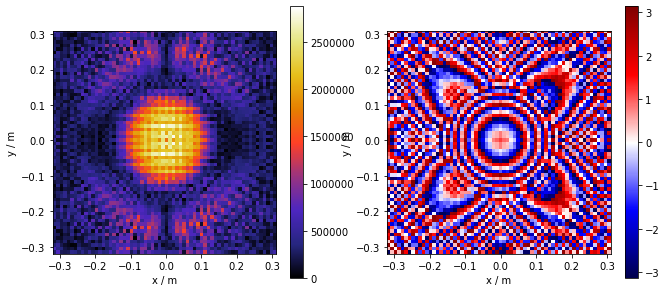

In [67]:
propagated = SingleComponentBeam.NearFieldProp(beam_S,5.0)
propagated.plot()
plt.show()

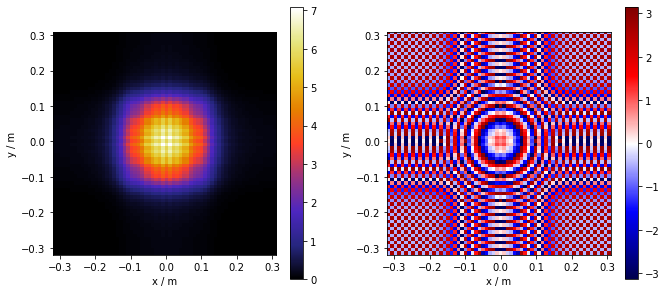

In [68]:
gbprop = SingleComponentBeam.NearFieldProp(gb,5.0)
gbprop.plot()
plt.show()

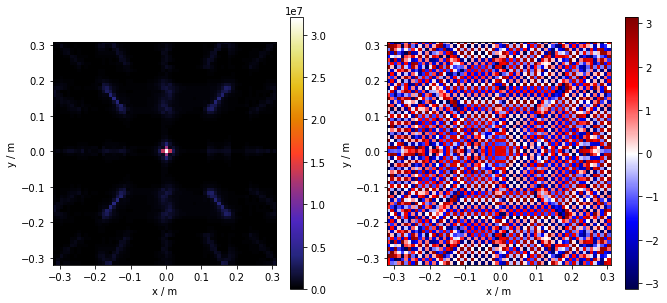

In [69]:
propagated = SingleComponentBeam.NearFieldProp(beam_S,-5.0)
propagated.plot()
plt.show()

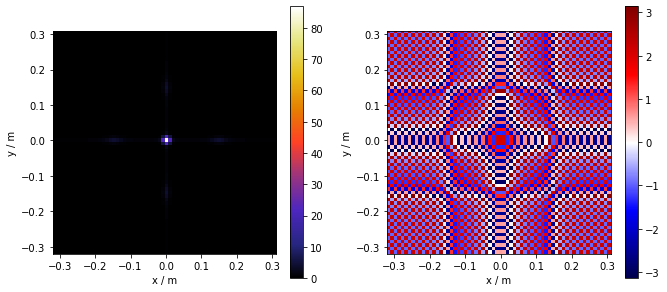

In [70]:
gbprop = SingleComponentBeam.NearFieldProp(gb,-5.0)
gbprop.plot()
plt.show()